<center>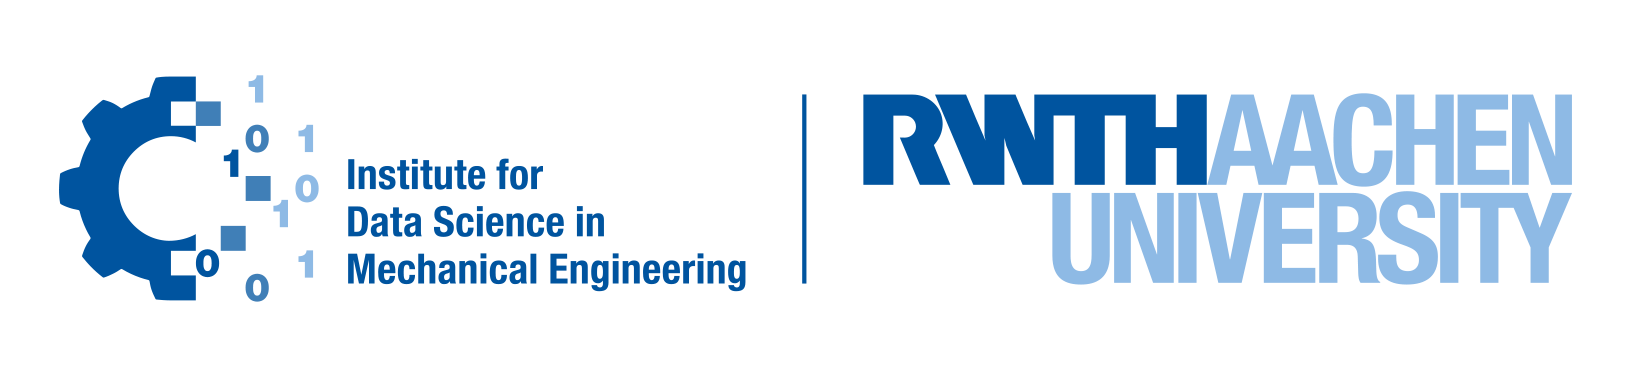</center>

**MOOC Learning-based Control** <br> 
RWTH Aachen University, DSME (Prof. Sebastian Trimpe, Paul Brunzema) <br>

---

# Tuning an LQR Controller of the Cart Pole with Bayesian Optimization

In this notebook, we will implement an automatic tuning approach of an LQR using Bayesian optimization.


In [1]:
import numpy as np
from scipy.linalg import solve_discrete_are
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

%matplotlib inline

## The Cart Pole System

<center>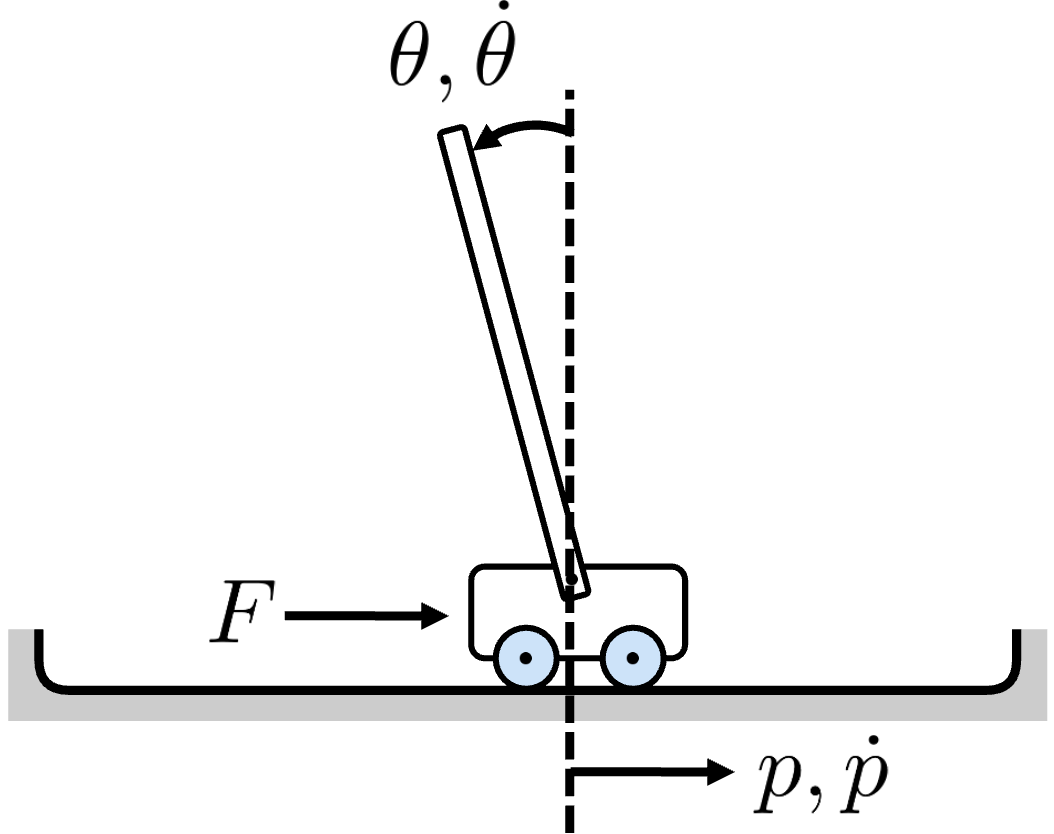</center>

A classic benchmark system in control and reinforcement learning

**States**

- position of the cart $p$
- angle of the pole $\theta$
- velocity of the cart $\dot p$ 
- angular velocity of the pole $\dot\theta$

**Input**

- Force applied to the cart $F$

In [2]:
# Example parameters
_DEFAULT_PARAMS = {
    "M": 1.0,  # Mass of cart (kg)
    "m": 0.1,  # Mass of pole (kg)
    "J": 0.01,  # Moment of inertia of pole (kg*m^2)
    "l": 0.5,  # Length to COM of pole (m)
    "c": 0.1,  # Cart friction coefficient
    "gamma": 0.01,  # Pole friction coefficient
    "g": 9.81,  # Gravity (m/s^2)
}


class CartPole:
    """
    Cart-pole system simulation model.
    """

    def __init__(self, params=None):
        """
        Initialize the cart-pole system with physical parameters.

        Args:
            params (dict): Parameters of the cart-pole system
        """
        self.params = {
            **_DEFAULT_PARAMS,
            **(params or {}),
        }

    def dynamics(self, t, state, u):
        """
        Compute the dynamics of the cart-pole system.

        Args:
            t (float): Time (not used in this system, but required for compatibility)
            state (numpy.ndarray): State vector [p, theta, dotp, theta_dot]
            u (float): Input force F

        Returns:
            numpy.ndarray: Time derivative of the state vector
        """
        # Extract state variables
        p, theta, p_dot, theta_dot = state

        # Extract parameters
        M = self.params["M"]  # Mass of the base (cart)
        m = self.params["m"]  # Mass of the pole
        J = self.params["J"]  # Moment of inertia of the pole
        l = self.params["l"]  # Distance from base to center of mass
        c = self.params["c"]  # Coefficient of viscous friction for cart
        gamma = self.params["gamma"]  # Coefficient of viscous friction for pole
        g = self.params["g"]  # Gravity acceleration

        # Compute total mass and total inertia
        Mt = M + m
        Jt = J + m * l**2

        # Compute sine and cosine of theta (using shorthand from equations)
        s_theta = np.sin(theta)
        c_theta = np.cos(theta)

        # First two state derivatives (directly from state definition)
        dp = p_dot
        dtheta = theta_dot

        # Third derivative (ddp) - cart acceleration
        numerator_p_ddot = (
            -m * l * s_theta * theta_dot**2
            + m * g * (m * l**2 / Jt) * s_theta * c_theta
            - c * p_dot
            - (gamma / Jt) * m * l * c_theta * theta_dot
            + u
        )
        denominator_p_ddot = Mt - m * (m * l**2 / Jt) * c_theta**2
        dp_dot = numerator_p_ddot / denominator_p_ddot

        # Fourth derivative (ddtheta) - pole angular acceleration
        numerator_theta_ddot = (
            -m * l**2 * s_theta * c_theta * theta_dot**2
            + Mt * g * l * s_theta
            - c * l * c_theta * p_dot
            - gamma * (Mt / m) * theta_dot
            + l * c_theta * u
        )
        denominator_theta_ddot = Jt * (Mt / m) - m * (l * c_theta) ** 2
        dtheta_dot = numerator_theta_ddot / denominator_theta_ddot

        # Combine into the derivative of the state vector
        dx = np.array([dp, dtheta, dp_dot, dtheta_dot])
        return dx

    def get_upper_linearized_dynamics(self):
        """
        Compute the linearized dynamics of the cart-pole system of the upper equilibrium point.

        Returns:
            tuple: A tuple containing:
                numpy.ndarray: A - State matrix
                numpy.ndarray: B - Input matrix
        """
        # Extract parameters
        M = self.params["M"]  # Mass of the base (cart)
        m = self.params["m"]  # Mass of the pole
        J = self.params["J"]  # Moment of inertia of the pole
        l = self.params["l"]  # Distance from base to center of mass
        c = self.params["c"]  # Coefficient of viscous friction for cart
        gamma = self.params["gamma"]  # Coefficient of viscous friction for pole
        g = self.params["g"]  # Gravity acceleration

        # Compute total mass and total inertia
        Mt = M + m
        Jt = J + m * l**2
        mu = Mt * Jt - m**2 * l**2

        # State matrix
        A = np.array(
            [
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [0, m**2 * l**2 * g / mu, -c * Jt / mu, -gamma * l * m / mu],
                [0, Mt * m * g * l / mu, -c * l * m / mu, -gamma * Mt / mu],
            ]
        )

        # Input matrix
        B = np.array([[0], [0], [Jt / mu], [l * m / mu]])
        return A, B

    def rk4_step(self, state, u, dt):
        """
        Single RK4 integration step.
        (https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)

        Args:
            state: Current state vector
            u: Control input
            dt: Time step

        Returns:
            Next state after one RK4 step
        """
        k1 = self.dynamics(0, state, u)
        k2 = self.dynamics(0, state + dt / 2 * k1, u)
        k3 = self.dynamics(0, state + dt / 2 * k2, u)
        k4 = self.dynamics(0, state + dt * k3, u)

        next_state = state + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return next_state

    def simulate(
        self,
        initial_state,
        controller=None,
        t_span=(0, 5),
        dt_sim=0.01,
        dt_control=0.02,
        reference_func=None,  # Added reference function
    ):
        """
        Simulate the system with a controller.

        Args:
            initial_state (array): Initial state [x, theta, x_dot, theta_dot]
            controller (function): Control law u = f(t, state)
            t_span (tuple): Time span (t_start, t_end)
            dt_sim (float): Simulation time step (for physics)
            dt_control (float): Control update interval (for controller)
            reference_func (function): Function that returns the reference state at a given time.

        Returns:
            tuple: A tuple containing (time_array, state_array, control_array, reference_array)
        """
        # Create time array for simulation
        t = np.arange(t_span[0], t_span[1], dt_sim)
        n_steps = len(t)

        # Initialize state and control arrays
        x = np.zeros((4, n_steps))
        u = np.zeros(n_steps)
        reference_states = np.zeros((4, n_steps))
        x[:, 0] = initial_state

        # Initialize control time and value
        next_control_time = t_span[0]
        current_control = 0.0

        # Simple fixed-step Runge-Kutta 4 integration
        for i in range(n_steps - 1):
            current_time = t[i]

            # Get reference state
            if reference_func is not None:
                current_reference = reference_func(current_time)
                reference_states[:, i] = current_reference
            else:
                current_reference = np.zeros(4)  # default to zero reference
                reference_states[:, i] = current_reference

            # Update control only at control frequency
            if current_time >= next_control_time:
                if controller is not None:
                    # Pass current_reference to the controller if it supports it
                    if hasattr(controller, "set_reference"):
                        controller.set_reference(current_reference)
                    current_control = controller(current_time, x[:, i])
                else:
                    current_control = 0.0
                next_control_time = current_time + dt_control

            # Store the current control value
            u[i] = current_control

            # RK4 integration step
            x[:, i + 1] = self.rk4_step(x[:, i], u[i], dt_sim)

        # Set the last control value and reference
        u[-1] = current_control
        if reference_func is not None:
            reference_states[:, -1] = reference_func(t[-1])
        else:
            reference_states[:, -1] = np.zeros(4)

        return t, x, u, reference_states


### Vizualizing utilities


In [3]:
def plot_trajectories(
    time,
    states,
    controls,
    references=None,
    title="Cart-Pole Trajectories",
    labels=None,
    costs=None,
):
    """
    Plot cart-pole trajectories with optional comparison between up to 4 controllers.

    Args:
        time: Time array OR tuple (time1, time2, ...) for comparison (up to 4)
        states: State array OR tuple (states1, states2, ...) for comparison (up to 4)
        controls: Control array OR tuple (controls1, controls2, ...) for comparison (up to 4)
        references: Reference array (same for all) or None
        title: Plot title
        labels: List/tuple of labels for trajectories (auto-generated if None)
        costs: List/tuple of costs for trajectories (optional)
    """
    # Check if inputs are tuples (comparison mode) or single arrays
    if isinstance(time, tuple):
        # Comparison mode - determine number of trajectories
        n_traj = len(time)
        if n_traj > 4:
            raise ValueError("Maximum 4 trajectories supported")

        times = time
        states_list = states
        controls_list = controls
        is_comparison = n_traj > 1
    else:
        # Single trajectory mode
        n_traj = 1
        times = (time,)
        states_list = (states,)
        controls_list = (controls,)
        is_comparison = False

    # Set default labels if not provided
    if labels is None:
        if n_traj == 1:
            labels = ("Controller",)
        else:
            labels = tuple(f"Controller {i + 1}" for i in range(n_traj))

    # Set default costs if not provided
    if costs is None:
        costs = tuple(None for _ in range(n_traj))

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Build title with costs if provided
    title_str = title
    if any(cost is not None for cost in costs) and is_comparison:
        cost_strs = []
        for i, (label, cost) in enumerate(zip(labels, costs)):
            if cost is not None:
                cost_strs.append(f"{label}: {cost:.2f}")
        if cost_strs:
            title_str += f"\nCosts: {', '.join(cost_strs)}"
    elif costs[0] is not None:
        title_str += f"\nCost: {costs[0]:.2f}"

    fig.suptitle(title_str, fontsize=14)

    # Define line styles for up to 4 trajectories (same colors, different styles)
    base_colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange"]
    linestyles = [
        "-",
        "--",
        "-.",
        ":",
        (0, (3, 1, 1, 1)),
    ]  # solid, dashed, dashdot, dotted, custom
    linewidths = [2.5, 2.0, 2.0, 2.0]  # slightly thicker for first trajectory

    # Position and Angle subplot
    ax1 = axes[0]

    # Plot reference trajectories first (same for all)
    if references is not None:
        ax1.plot(
            times[0],
            references[0, :],
            color="tab:blue",
            linestyle=":",
            linewidth=1,
            alpha=0.7,
            label="Position Ref",
        )
        ax1.plot(
            times[0],
            references[1, :],
            color="tab:red",
            linestyle=":",
            linewidth=1,
            alpha=0.7,
            label="Angle Ref",
        )

    # Plot all trajectories
    for i in range(n_traj):
        # Position
        ax1.plot(
            times[i],
            states_list[i][0, :],
            color=base_colors[0],
            linestyle=linestyles[i],
            linewidth=linewidths[i],
            label=f"Position ({labels[i]})",
        )
        # Angle
        ax1.plot(
            times[i],
            states_list[i][1, :],
            color=base_colors[1],
            linestyle=linestyles[i],
            linewidth=linewidths[i],
            label=f"Angle ({labels[i]})",
        )

    ax1.set_ylabel("Position [m], Angle [rad]")
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax1.set_title("Position and Angle Tracking")

    # Velocities subplot
    ax2 = axes[1]
    ax2.axhline(0, color="gray", linestyle=":", alpha=0.7)

    # Plot reference velocities (same for all)
    if references is not None:
        ax2.plot(
            times[0],
            references[2, :],
            color="black",
            linestyle=":",
            linewidth=1,
            alpha=0.7,
            label="Cart Vel. Ref",
        )
        ax2.plot(
            times[0],
            references[3, :],
            color="black",
            linestyle=":",
            linewidth=1,
            alpha=0.7,
            label="Ang. Vel. Ref",
        )

    # Plot all trajectories
    for i in range(n_traj):
        # Cart velocity
        ax2.plot(
            times[i],
            states_list[i][2, :],
            color=base_colors[2],
            linestyle=linestyles[i],
            linewidth=linewidths[i],
            label=f"Cart Velocity ({labels[i]})",
        )
        # Angular velocity
        ax2.plot(
            times[i],
            states_list[i][3, :],
            color=base_colors[3],
            linestyle=linestyles[i],
            linewidth=linewidths[i],
            label=f"Pole Ang. Velocity ({labels[i]})",
        )

    ax2.set_ylabel("Velocities [m/s], [rad/s]")
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax2.set_title("Velocities")

    # Control subplot
    ax3 = axes[2]
    ax3.axhline(0, color="gray", linestyle=":", alpha=0.7)

    # Plot all control trajectories
    colors = ["tab:orange", "k", "darkorange", "lightcoral"]
    for i in range(n_traj):
        ax3.step(
            times[i],
            controls_list[i],
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=linewidths[i],
            label=f"Control ({labels[i]})",
            where="post",
        )

    ax3.set_ylabel("Control Force [N]")
    ax3.set_xlabel("Time [s]")
    ax3.grid(True, alpha=0.3)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax3.set_title("Control Input")

    plt.tight_layout()
    plt.show()

## Defining the state-feedback controller


In [4]:
class AbstractController(ABC):
    def __init__(self):
        self.reference_state_func = None

    @abstractmethod
    def __call__(self, t, state):
        pass

    def set_reference_state_func(self, ref_func):
        self.reference_state_func = ref_func


class LinearFeedbackController(AbstractController):
    def __init__(self, K):
        super().__init__()
        self.K = K
        self.current_reference = np.zeros(4)  # Initialize with zero reference

    def set_reference(self, reference_state):
        self.current_reference = reference_state

    def __call__(self, t, state):
        # If a reference function is provided, use it to get the current reference
        if self.reference_state_func is not None:
            self.current_reference = self.reference_state_func(t)

        # LQR control law for tracking: u = -K * (state - reference_state)
        u = -self.K @ (state - self.current_reference)
        return u.item()

In [5]:
def compute_dlqr_gains(Ad, Bd, Q, R):
    P = solve_discrete_are(Ad, Bd, Q, R)
    K = np.linalg.inv(R + Bd.T @ P @ Bd) @ Bd.T @ P @ Ad
    return K

### Defining an experiment with the Cart Pole

In [6]:
def run_experiment(
    self,
    Q_matrix,
    R_matrix,
    initial_state,
    dt_control=0.02,
    t_span=(0, 10),
    reference_changes=None,
):
    """
    Runs an experiment with an LQR controller tuned with the given Q and R matrices.
    The experiment includes various reference changes.

    Args:
        Q_matrix (np.ndarray): The state cost matrix for the LQR controller.
        R_matrix (np.ndarray): The control cost matrix for the LQR controller.
        initial_state (np.ndarray): The initial state of the cart-pole system.
        dt_control (float): Control update interval.
        t_span (tuple): Time span for the simulation (t_start, t_end).
        reference_changes (list of dict): A list describing reference changes.
                                            Each dict should have 'time' and 'reference_state'.

    Returns:
        float: The calculated cost of the experiment.
        tuple: (time_array, state_array, control_array, reference_array) from the simulation.
    """
    # 1. Initialize a new LQR controller with the given Q and R matrices
    A, B = self.get_upper_linearized_dynamics()
    A_discrete = np.eye(4) + A * dt_control
    B_discrete = B * dt_control

    try:
        K_LQR = compute_dlqr_gains(A_discrete, B_discrete, Q_matrix, R_matrix)
    except np.linalg.LinAlgError as e:
        print(f"LQR gain computation failed: {e}.")
        return np.inf, None, None, None, None

    lqr_controller = LinearFeedbackController(K_LQR)

    # 2. Define the reference function for the experiment
    def experiment_reference_func(current_time):
        # Default reference is upright pole at position 0
        ref_state = np.array([0.0, 0.0, 0.0, 0.0])
        if reference_changes:
            for change in reference_changes:
                if current_time >= change["time"]:
                    ref_state = change["reference_state"]
        return ref_state

    # Make sure the LQR controller knows how to handle the reference
    if hasattr(lqr_controller, "set_reference"):
        lqr_controller.set_reference_state_func(experiment_reference_func)

    # 3. Run the simulation
    t, x, u, reference_states = self.simulate(
        initial_state,
        controller=lqr_controller,
        t_span=t_span,
        dt_control=dt_control,
        reference_func=experiment_reference_func,
    )

    # 4. Calculate a comprehensive cost function combining multiple objectives
    tracking_error = x - reference_states
    dt_sim = t[1] - t[0] if len(t) > 1 else dt_control

    # ITAE cost for position and angle tracking (emphasizes faster settling)
    itae_cost = 0.0
    for i in range(len(t)):
        position_error = np.abs(tracking_error[0, i])
        angle_error = np.abs(tracking_error[1, i])
        total_error = position_error + angle_error
        itae_cost += t[i] * total_error * dt_sim

    # ISE cost for velocity states (penalizes oscillations)
    ise_velocity_cost = 0.0
    for i in range(len(t)):
        velocity_error = tracking_error[2, i] ** 2  # cart velocity error squared
        angular_velocity_error = (
            tracking_error[3, i] ** 2
        )  # pole angular velocity error squared
        ise_velocity_cost += (velocity_error + angular_velocity_error) * dt_sim

    # Control effort penalty (energy consumption)
    control_effort_cost = np.sum(u**2 * dt_sim)

    # Control smoothness penalty (reduces actuator wear)
    control_smoothness_cost = 0.0
    if len(u) > 1:
        control_diff = np.diff(u)
        control_smoothness_cost = np.sum(control_diff**2) * dt_sim

    # Combine all costs with weights
    total_cost = (
        1.0 * itae_cost  # Primary tracking objective
        + 0.5 * ise_velocity_cost  # Damping/smoothness
        + 0.2 * control_effort_cost  # Energy efficiency
        + 0.2 * control_smoothness_cost  # Actuator wear
    )

    return total_cost, t, x, u, reference_states


CartPole.run_experiment = run_experiment

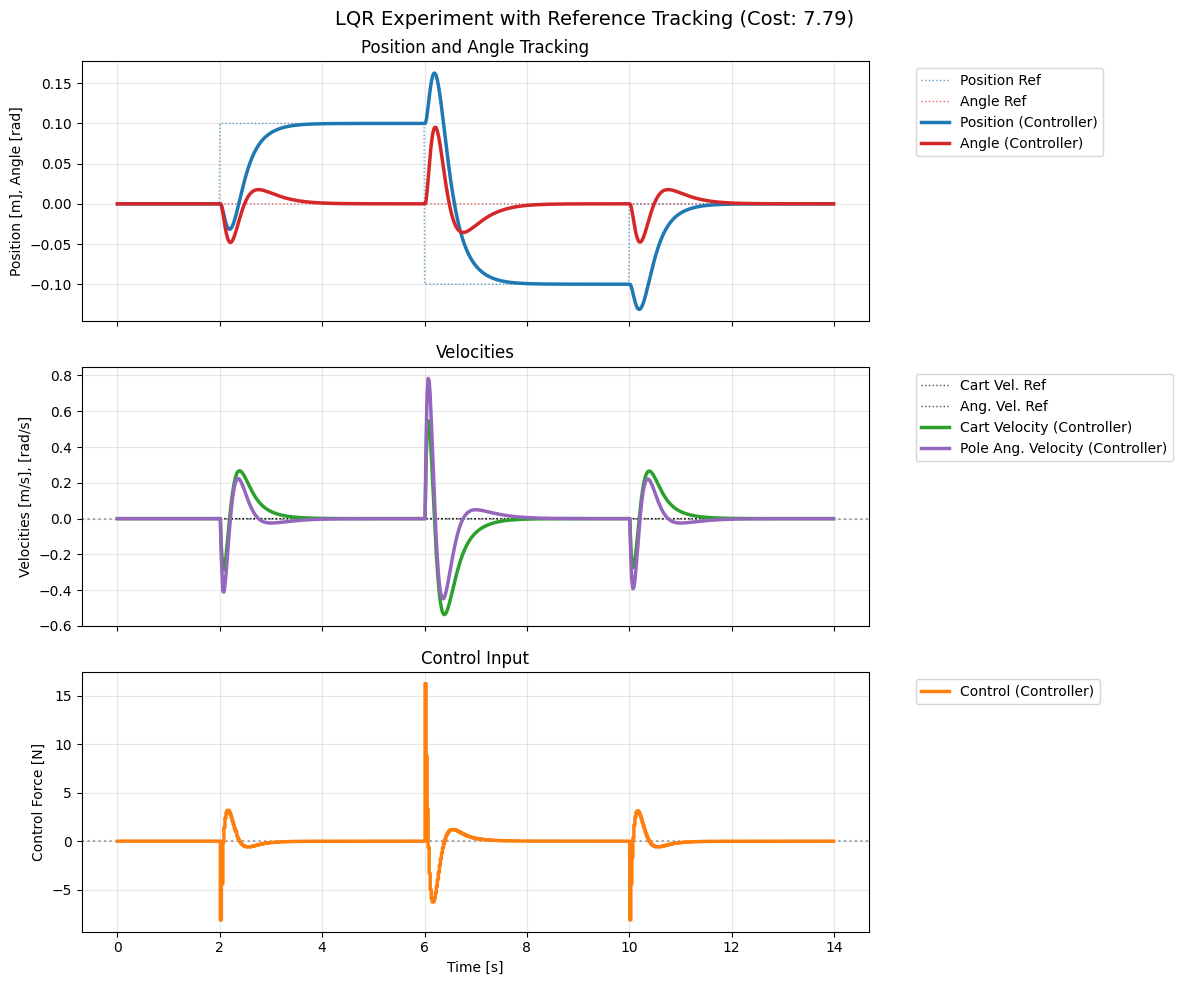

In [7]:
cart_pole = CartPole()
x0 = np.array([0.0, 0.0, 0.0, 0.0])  # Initial state for the first plot


# Define reference changes for the experiment
experiment_reference_changes = [
    {
        "time": 0.0,
        "reference_state": np.array(
            [0.0, 0.0, 0.0, 0.0]
        ),  # in meters, radians, m/s, rad/s
    },
    {
        "time": 2.0,
        "reference_state": np.array(
            [0.1, 0.0, 0.0, 0.0]
        ),  # in meters, radians, m/s, rad/s
    },
    {
        "time": 6.0,
        "reference_state": np.array(
            [-0.1, 0.0, 0.0, 0.0]
        ),  # in meters, radians, m/s, rad/s
    },
    {
        "time": 10.0,
        "reference_state": np.array(
            [0.00, 0.0, 0.0, 0.0]
        ),  # in meters, radians, m/s, rad/s
    },
]

# Example Q and R for the experiment
Q_experiment = np.diag([100.0, 1.0, 0.001, 0.001])
R_experiment = np.array([[0.01]])

# Run the experiment
experiment_cost, t_exp, x_exp, u_exp, ref_exp = cart_pole.run_experiment(
    Q_matrix=Q_experiment,
    R_matrix=R_experiment,
    initial_state=x0,
    t_span=(0, 14),
    reference_changes=experiment_reference_changes,
)

plot_trajectories(
    t_exp,
    x_exp,
    u_exp,
    ref_exp,
    title=f"LQR Experiment with Reference Tracking (Cost: {experiment_cost:.2f})",
)

## LQR Tuning with Bayesian Optimization


In [8]:
import torch
from botorch.test_functions import SyntheticTestFunction
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.utils.transforms import unnormalize
from botorch.models.transforms.outcome import Standardize
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.constraints import Interval

### Class for Black-Box Function following BoTorch Syntax


In [9]:
class CartPoleControllerTuning(SyntheticTestFunction):
    dim = 5
    dtype = torch.double

    def __init__(
        self, cart_pole, noise_std=None, negate=False, bounds=None, dtype=torch.double
    ):
        bounds = bounds or torch.tensor(
            [
                [0.001, 10.0],  # Q_11
                [0.001, 10.0],  # Q_22
                [0.001, 10.0],  # Q_33
                [0.001, 10.0],  # Q_44
                [0.01, 10.0],  # R_11
            ],
            dtype=dtype,
        )
        super().__init__(noise_std, negate, bounds, dtype)

        self.cart_pole = cart_pole

        self.base_Q = np.diag([100.0, 1.0, 0.001, 0.001])
        self.base_R = np.array([[0.01]])
        self.initial_state = np.array([0.0, 0.0, 0.0, 0.0])
        self.t_span = (0, 14)
        self.reference_changes = experiment_reference_changes

    def perform_experiment(self, Q_matrix, R_matrix):
        """
        Run the cart-pole experiment with the given Q and R matrices.

        Args:
            Q_matrix (np.ndarray): The state cost matrix for the LQR controller.
            R_matrix (np.ndarray): The control cost matrix for the LQR controller.

        Returns:
            float: The calculated cost of the experiment.
        """
        cost, _, _, _, _ = self.cart_pole.run_experiment(
            Q_matrix=Q_matrix,
            R_matrix=R_matrix,
            initial_state=self.initial_state,
            t_span=self.t_span,
            reference_changes=self.reference_changes,
        )
        return cost

    def evaluate_true(self, X):
        """
        Evaluate the function (w/o observation noise) on a set of points.

        Args:
            X: A `(batch_shape) x d`-dim tensor of point(s) at which to
                evaluate.

        Returns:
            A `batch_shape`-dim tensor.
        """
        # Handle both single point and batch evaluation
        if X.dim() == 1:
            X = X.unsqueeze(0)  # Add batch dimension
            single_point = True
        else:
            single_point = False

        batch_size = X.shape[0]
        results = torch.zeros(batch_size, dtype=self.dtype, device=X.device)

        for i in range(batch_size):
            # Construct Q and R matrices from input X[i]
            Q_matrix = self.base_Q.copy()
            R_matrix = self.base_R.copy()
            Q_matrix[0, 0] = X[i, 0].item()  # Position weight
            Q_matrix[1, 1] = X[i, 1].item()  # Angle weight
            Q_matrix[2, 2] = X[i, 2].item()  # Angle weight
            Q_matrix[3, 3] = X[i, 3].item()  # Angle weight
            R_matrix[0, 0] = X[i, 4].item()  # Control weight

            # Run the experiment and get the cost
            cost = self.perform_experiment(Q_matrix, R_matrix)
            results[i] = cost

        # Remove batch dimension if input was a single point
        if single_point:
            results = results.squeeze(0)

        # Apply negation if specified
        if self.negate:
            results = -results

        return results


cart_pole = CartPole()
function = CartPoleControllerTuning(cart_pole)

/Users/paulbrunzema/Documents/02_Code_Bases/mooc_lbc/.venv/lib/python3.11/site-packages/botorch/test_functions/base.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self._bounds, dtype=dtype).transpose(-1, -2),


In [10]:
def evaluate_parameters(X):
    """
    Evaluate the function on a set of points.

    Args:
        X: A `(batch_shape) x d`-dim tensor of point(s) at which to evaluate.

    Returns:
        A `batch_shape`-dim tensor.
    """
    X_unnormalized = unnormalize(X, function.bounds)
    return function.evaluate_true(X_unnormalized)

### BO Loop


In [11]:
N_INITIAL = function.dim
ITERATIONS = 100
SEED = 42

# Set random seed for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)

# generate initial training data using Sobol sequence
sobol = torch.quasirandom.SobolEngine(dimension=function.dim, scramble=True)
x_train = sobol.draw(N_INITIAL).to(function.dtype)
y_train = evaluate_parameters(x_train)

for iteration in range(ITERATIONS):
    
    # Create a Gaussian process surrogate model
    covar_module = ScaleKernel(
        MaternKernel(
            nu=2.5,
            lengthscale_constraint=Interval(0.0005, 4.0),
            ard_num_dims=function.dim,  # individual lengthscales for each dimension
        ),
    )

    model = SingleTaskGP(
        covar_module=covar_module,
        train_X=x_train,
        train_Y=y_train.unsqueeze(-1),  # explicit output dimension
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)  # learn hyperparameters

    # Create an acquisition function
    acq_func = LogExpectedImprovement(
        model=model,
        best_f=y_train.min(),  # necessary for EI
        maximize=False,  # We want to minimize the cost
    )
    x_next, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.stack(
            [
                torch.zeros(function.dim),
                torch.ones(function.dim),
            ]
        ),
        q=1,  # We want to find one point -> "batch size" of 1
        num_restarts=10,  # Number of restarts for optimization
        raw_samples=512,  # Number of raw samples for optimization
    )

    # Evaluate the true function at the new candidate point
    new_y = evaluate_parameters(x_next)

    # Append the new data to the training set
    x_train = torch.cat([x_train, x_next])
    y_train = torch.cat([y_train, new_y])
    print(f"Iteration {iteration + 1:>3}/{ITERATIONS}\tBest cost so far: {y_train.min().item():.4f}")


Iteration   1/100	Best cost so far: 3.9349
Iteration   2/100	Best cost so far: 3.9349
Iteration   3/100	Best cost so far: 3.9127
Iteration   4/100	Best cost so far: 3.7096
Iteration   5/100	Best cost so far: 3.7096
Iteration   6/100	Best cost so far: 3.7096
Iteration   7/100	Best cost so far: 3.7095
Iteration   8/100	Best cost so far: 3.6578
Iteration   9/100	Best cost so far: 3.6578
Iteration  10/100	Best cost so far: 3.6578
Iteration  11/100	Best cost so far: 3.6578
Iteration  12/100	Best cost so far: 3.6578
Iteration  13/100	Best cost so far: 3.6578
Iteration  14/100	Best cost so far: 3.6578
Iteration  15/100	Best cost so far: 3.6578
Iteration  16/100	Best cost so far: 3.6578
Iteration  17/100	Best cost so far: 3.6578
Iteration  18/100	Best cost so far: 3.6578
Iteration  19/100	Best cost so far: 3.6578
Iteration  20/100	Best cost so far: 3.6578
Iteration  21/100	Best cost so far: 3.6578
Iteration  22/100	Best cost so far: 3.6341
Iteration  23/100	Best cost so far: 3.6280
Iteration  

In [12]:
# random baseline
x_random = sobol.draw(N_INITIAL + ITERATIONS).to(function.dtype)
y_random = evaluate_parameters(x_random)

### Quantitative and Qualitative Comparison


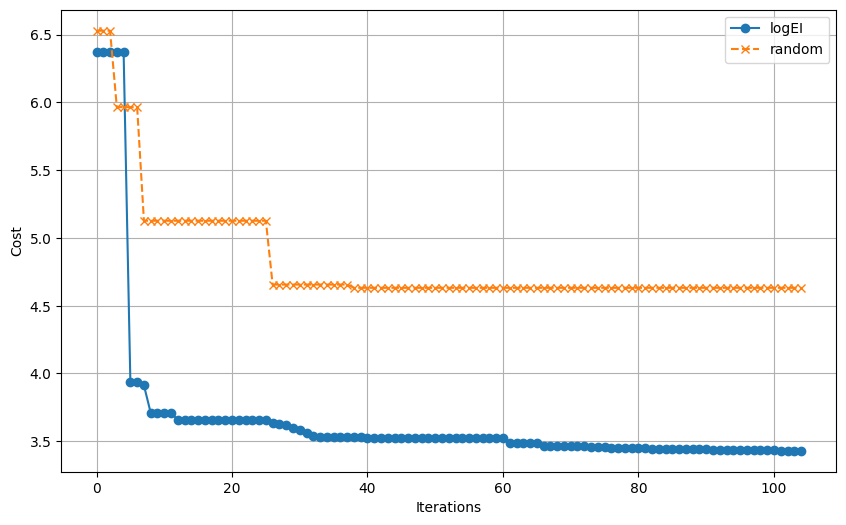

In [13]:
# Plot the results
y_best_over_time = np.minimum.accumulate(y_train.numpy())
y_random_bes_over_time = np.minimum.accumulate(y_random.numpy())

plt.figure(figsize=(10, 6))
plt.plot(
    y_best_over_time,
    "o-",
    label="logEI",
)
plt.plot(
    y_random_bes_over_time,
    "x--",
    label="random",
)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# results with best parameters
x_best = x_train[y_train.argmin()]
x_best = unnormalize(x_best.unsqueeze(0), function.bounds).squeeze(0)
Q_best = function.base_Q.copy()
Q_best[0, 0] = x_best[0].item()
Q_best[1, 1] = x_best[1].item()
Q_best[2, 2] = x_best[2].item()
Q_best[3, 3] = x_best[3].item()
R_best = function.base_R.copy()
R_best[0, 0] = x_best[4].item()

print(f"Best Q matrix:\n{Q_best}")
print(f"Best R matrix:\n{R_best}")

Best Q matrix:
[[3.67669998e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e-03]]
Best R matrix:
[[0.01]]


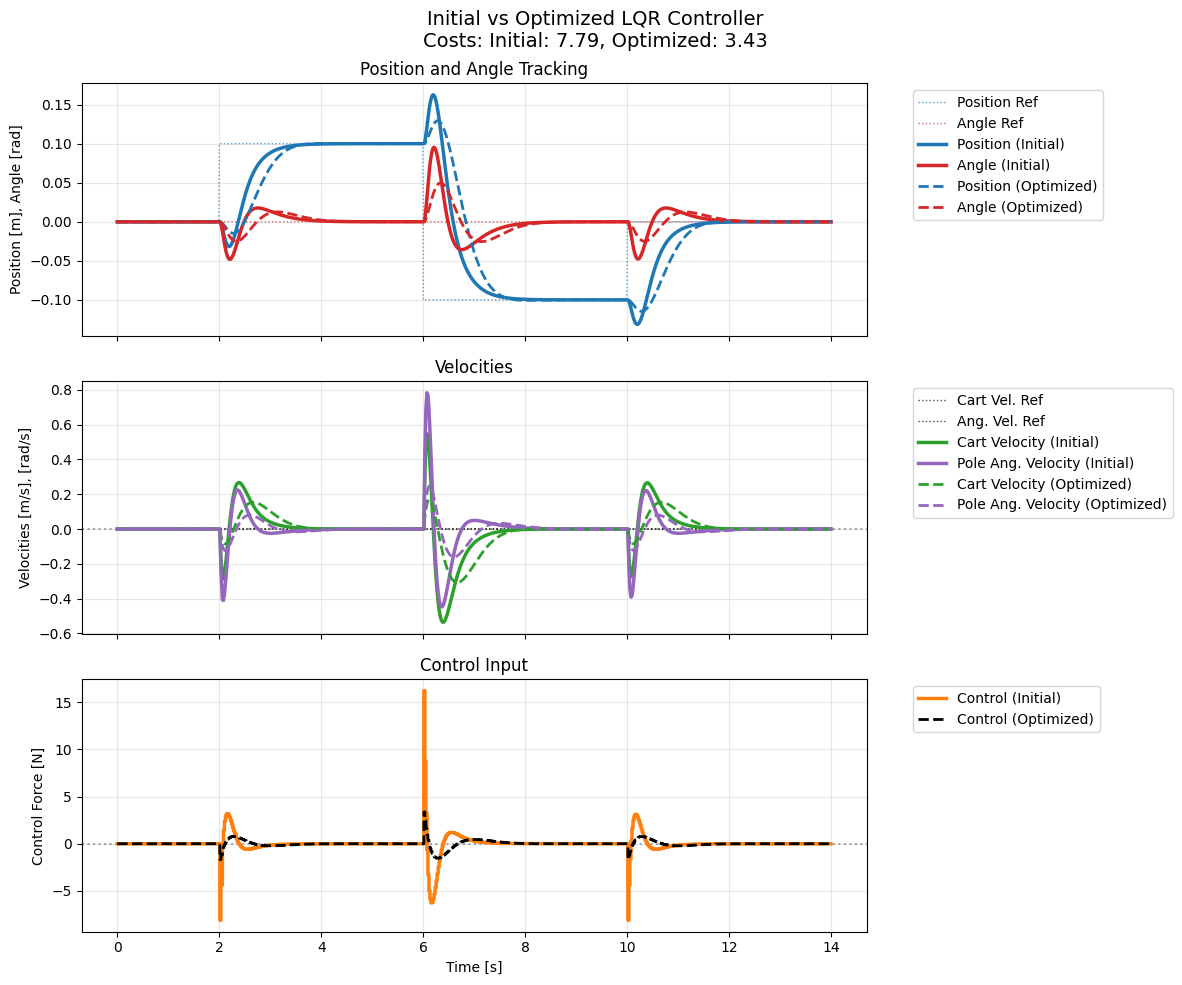

In [15]:
# Run the experiment
experiment_cost_opt, t_opt, x_opt, u_opt, ref_opt = cart_pole.run_experiment(
    Q_matrix=Q_best,
    R_matrix=R_best,
    initial_state=x0,
    t_span=(0, 14),
    reference_changes=experiment_reference_changes,
)

plot_trajectories(
    (t_exp, t_opt),
    (x_exp, x_opt),
    (u_exp, u_opt),
    ref_exp,  # references are the same for all
    title="Initial vs Optimized LQR Controller",
    labels=("Initial", "Optimized"),
    costs=(experiment_cost, experiment_cost_opt),
)


---
<center>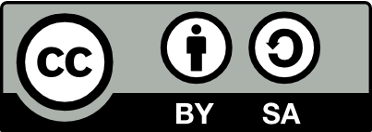</center>

This work was originally created by Sebastian Trimpe and Paul Brunzema. <br> 
It is licensed under Attribution-ShareAlike 4.0 International [(CC-BY-SA 4.0)](https://creativecommons.org/licenses/by-sa/4.0/).